This block of codes estimates the Ecosystem Service Valuation (ESV) for  Dynamic Estimation Using KNDVI Trends. Using several methods to Implement Dynamic ESV such as GradientBoosting, Advanced Machine Learning Models (XGBoost), Random Forest and Ensemble Modeling Approach to estimate ESV.

@Author: Pius Nwachukwu

# 3rd Phase:
# Step 1. Dynamic ESV Estimation Using KNDVI Trends


In [ ]:
!pip install eemont
!pip install wxee
!pip install earthengine-api

In [ ]:
import ee, eemont, wxee, pandas as pd


In [ ]:
# Authenticate and initialize the Earth Engine module.
ee.Authenticate()
ee.Initialize(project='ee-')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load datasets
chirps_file =  pd.read_csv("/content/drive/My Drive/CHIRPS_exports/CHIRPS_Monthly_TimeSeries_Fixed.csv")
esv_file = pd.read_csv("/content/drive/My Drive/ESV_Data/Filtered_ESV.csv")
kndvi_file = pd.read_csv("/content/drive/My Drive/NDVI_Time_Series_With_Country_Continent25.csv")

# Confirm column names for each dataset
print("NDVI Dataset Columns:")
print(kndvi_file.columns)

print("\nCHIRPS Dataset Columns:")
print(chirps_file.columns)

print("\nESV Dataset Columns:")
print(esv_file.columns)


NDVI Dataset Columns:
Index(['system:index', 'Continent', 'Country', 'Latitude', 'Longitude', 'date',
       'mean', '.geo', 'NDVI_Ref', 'KNDVI'],
      dtype='object')

CHIRPS Dataset Columns:
Index(['system:index', 'Continent', 'Countries', 'Latitude', 'Longitude',
       'date', 'mean', '.geo'],
      dtype='object')

ESV Dataset Columns:
Index(['Continent', 'year', 'month', 'ESVD2.0_Biome',
       'Int$ Per Hectare Per Year', 'date'],
      dtype='object')


In [ ]:
# Clean and prepare the Data
# Drop 'Countries' from CHIRPS dataset and 'Country' from NDVI dataset
kndvi_file.drop(columns=['Country'], inplace=True, errors='ignore')
chirps_file.drop(columns=['Countries'], inplace=True, errors='ignore')

# Confirm the changes by displaying the columns
print("NDVI Dataset Columns After Dropping Country:")
print(kndvi_file.columns)

print("\nCHIRPS Dataset Columns After Dropping Countries:")
print(chirps_file.columns)

NDVI Dataset Columns After Dropping Country:
Index(['system:index', 'Continent', 'Latitude', 'Longitude', 'date', 'mean',
       '.geo', 'NDVI_Ref', 'KNDVI'],
      dtype='object')

CHIRPS Dataset Columns After Dropping Countries:
Index(['system:index', 'Continent', 'Latitude', 'Longitude', 'date', 'mean',
       '.geo'],
      dtype='object')


In [ ]:
# Conver the date columns to datetime and extract the years

# Convert date columns to datetime format
kndvi_file['date'] = pd.to_datetime(kndvi_file['date'], errors='coerce')
chirps_file['date'] = pd.to_datetime(chirps_file['date'], errors='coerce')
esv_file['date'] = pd.to_datetime(esv_file['date'], errors='coerce')


# Extract month for seasonal grouping
chirps_file['month'] = chirps_file['date'].dt.month
esv_file['month'] = esv_file['date'].dt.month
kndvi_file['month'] = kndvi_file['date'].dt.month

# Extract the year from the date column and create a new 'year' column
kndvi_file['year'] = kndvi_file['date'].dt.year  # Adding this line to extract year
chirps_file['year'] = chirps_file['date'].dt.year  # Adding this line to extract year
# Confirm the new column has been added correctly
print("NDVI Dataset After Adding Year Column:")
print(kndvi_file[['date', 'year']].head())

print("\nCHIRPS Dataset After Adding Year Column:")
print(chirps_file[['date', 'year']].head())



# kndvi_df.rename(columns={'mean': 'KNDVI_Value'}, inplace=True)
# esv_df.rename(columns={'Int$ Per Hectare Per Year': 'ESV_Value'}, inplace=True)

NDVI Dataset After Adding Year Column:
        date  year
0 2000-02-01  2000
1 2000-02-01  2000
2 2000-02-01  2000
3 2000-02-01  2000
4 2000-02-01  2000

CHIRPS Dataset After Adding Year Column:
        date  year
0 2000-01-01  2000
1 2000-01-01  2000
2 2000-01-01  2000
3 2000-01-01  2000
4 2000-01-01  2000


In [ ]:
print(esv_file['year'].unique())

[2010 2018 2021 2012 2016 2008 2022 2009 2013 2020 2019 2017 2015 2014
 2005 2002 2006 2007 2004 2000 2003 2001 2011]


In [ ]:
# Aggregate NDVI data by Continent and year, taking the mean of KNDVI
ndvi_agg = kndvi_file.groupby(['Continent', 'year'])['KNDVI'].mean().reset_index()

# Aggregate CHIRPS data by Continent and year, taking the mean of precipitation values
chirps_agg = chirps_file.groupby(['Continent', 'year'])['mean'].mean().reset_index()

# Rename columns for clarity
chirps_agg.rename(columns={'mean': 'Precipitation_mean'}, inplace=True)


# Display results
print("Aggregated NDVI Data:")
print(ndvi_agg.head())

print("\nAggregated CHIRPS Data:")
print(chirps_agg.head())

Aggregated NDVI Data:
  Continent  year     KNDVI
0    Africa  2000  0.752069
1    Africa  2001  0.758075
2    Africa  2002  0.758006
3    Africa  2003  0.758224
4    Africa  2004  0.764589

Aggregated CHIRPS Data:
  Continent  year  Precipitation_mean
0    Africa  2000           86.841330
1    Africa  2001           97.497208
2    Africa  2002          103.734505
3    Africa  2003           94.661875
4    Africa  2004           95.382422


In [ ]:
# Here's the code to prepare the ESV dataset:


# Select only relevant columns for analysis
esv_selected = esv_file[['Continent', 'year', 'ESVD2.0_Biome', 'Int$ Per Hectare Per Year']]

# Display the first few rows of the cleaned ESV dataset
print("Prepared ESV Data:")
print(esv_selected.head())

Prepared ESV Data:
  Continent  year                                      ESVD2.0_Biome  \
0    Europe  2010  Temperate forests and woodlands; Rivers and la...   
1    Europe  2010  Temperate forests and woodlands; Rivers and la...   
2    Europe  2010  Temperate forests and woodlands; Rivers and la...   
3    Europe  2010  Temperate forests and woodlands; Rivers and la...   
4    Europe  2010  Temperate forests and woodlands; Rivers and la...   

   Int$ Per Hectare Per Year  
0                   49.40485  
1                   49.40485  
2                   49.40485  
3                   49.40485  
4                   49.40485  


In [ ]:
# Here’s the code to perform the merge:

# Merge NDVI and CHIRPS data on Continent and year
ndvi_chirps_merged = pd.merge(ndvi_agg, chirps_agg, on=['Continent', 'year'], how='inner')

# Merge the combined NDVI-CHIRPS dataset with ESV dataset
final_merged_df = pd.merge(ndvi_chirps_merged, esv_selected, on=['Continent', 'year'], how='inner')

# Display the first few rows of the merged dataset
print("Final Merged Dataset:")
print(final_merged_df.head())

# Check the shape to confirm number of records
print("\nFinal Merged Dataset Shape:", final_merged_df.shape)

Final Merged Dataset:
  Continent  year     KNDVI  Precipitation_mean  \
0    Africa  2000  0.752069            86.84133   
1    Africa  2000  0.752069            86.84133   
2    Africa  2000  0.752069            86.84133   
3    Africa  2000  0.752069            86.84133   
4    Africa  2000  0.752069            86.84133   

                                       ESVD2.0_Biome  \
0  Tropical and subtropical forests; Coastal systems   
1  Tropical and subtropical forests; Coastal systems   
2  Tropical and subtropical forests; Coastal systems   
3  Tropical and subtropical forests; Coastal systems   
4  Tropical and subtropical forests; Coastal systems   

   Int$ Per Hectare Per Year  
0                   0.006142  
1                   0.006142  
2                   0.006142  
3                   0.006142  
4                   0.006142  

Final Merged Dataset Shape: (32412, 6)


In [ ]:
# Display summary statistics for numerical columns
print("Summary Statistics:\n")
print(final_merged_df.describe())

# Check for missing values
print("\nMissing Values:\n")
print(final_merged_df.isnull().sum())

Summary Statistics:

               year         KNDVI  Precipitation_mean  \
count  32412.000000  32412.000000        32412.000000   
mean    2014.387634      0.800531          124.444055   
std        5.901011      0.032611           52.824380   
min     2000.000000      0.749103           53.404204   
25%     2011.000000      0.780756           72.905512   
50%     2016.000000      0.788434          101.734554   
75%     2019.000000      0.826828          171.561672   
max     2022.000000      0.896823          229.987100   

       Int$ Per Hectare Per Year  
count               32412.000000  
mean                  685.471956  
std                  5833.096827  
min                     0.000000  
25%                     1.675221  
50%                     5.498800  
75%                    26.748117  
max                165725.675658  

Missing Values:

Continent                    0
year                         0
KNDVI                        0
Precipitation_mean           0
ESVD2.0_

# Step 2. Steps for Dynamic ESV Estimation:

In [ ]:
# Step 1: Data Preparation

from sklearn.preprocessing import StandardScaler

# Check for missing values
print("Missing values in the dataset:")
print(final_merged_df.isnull().sum())

# Drop rows with missing values
final_merged_df.dropna(inplace=True)

# Select features and target variable
features = ['KNDVI', 'Precipitation_mean']
target = 'esv_value'

# Scale the feature values
scaler = StandardScaler()
final_merged_df[features] = scaler.fit_transform(final_merged_df[features])

# Display the cleaned and prepared dataset
print("Prepared Dataset:")
print(final_merged_df.head())


Missing values in the dataset:
Continent                    0
year                         0
KNDVI                        0
Precipitation_mean           0
ESVD2.0_Biome                0
Int$ Per Hectare Per Year    0
dtype: int64
Prepared Dataset:
  Continent  year     KNDVI  Precipitation_mean  \
0    Africa  2000 -1.486088           -0.711855   
1    Africa  2000 -1.486088           -0.711855   
2    Africa  2000 -1.486088           -0.711855   
3    Africa  2000 -1.486088           -0.711855   
4    Africa  2000 -1.486088           -0.711855   

                                       ESVD2.0_Biome  \
0  Tropical and subtropical forests; Coastal systems   
1  Tropical and subtropical forests; Coastal systems   
2  Tropical and subtropical forests; Coastal systems   
3  Tropical and subtropical forests; Coastal systems   
4  Tropical and subtropical forests; Coastal systems   

   Int$ Per Hectare Per Year  
0                   0.006142  
1                   0.006142  
2              

In [ ]:
# Step 2:Impute missing values with the mean of the column
final_merged_df = final_merged_df.assign(esv_value=final_merged_df['Int$ Per Hectare Per Year'].fillna(final_merged_df['Int$ Per Hectare Per Year'].mean()))


# Confirm missing values are handled
print("Missing values after imputation:")
print(final_merged_df.isnull().sum())


Missing values after imputation:
Continent                    0
year                         0
KNDVI                        0
Precipitation_mean           0
ESVD2.0_Biome                0
Int$ Per Hectare Per Year    0
esv_value                    0
dtype: int64


In [ ]:
# Step 3: Feature Engineering (This operation Might be removed)

# Calculate year-over-year change in KNDVI and precipitation
final_merged_df['KNDVI_trend'] = final_merged_df.groupby('Continent')['KNDVI'].diff()
final_merged_df['precipitation_trend'] = final_merged_df.groupby('Continent')['Precipitation_mean'].diff()

# Fill missing values resulting from diff operation
final_merged_df.fillna(0, inplace=True)

# Display the updated dataset with new features
print(final_merged_df[['Continent', 'year', 'KNDVI', 'KNDVI_trend', 'Precipitation_mean', 'precipitation_trend', 'Int$ Per Hectare Per Year']].head())


  Continent  year     KNDVI  KNDVI_trend  Precipitation_mean  \
0    Africa  2000 -1.486088          0.0           -0.711855   
1    Africa  2000 -1.486088          0.0           -0.711855   
2    Africa  2000 -1.486088          0.0           -0.711855   
3    Africa  2000 -1.486088          0.0           -0.711855   
4    Africa  2000 -1.486088          0.0           -0.711855   

   precipitation_trend  Int$ Per Hectare Per Year  
0                  0.0                   0.006142  
1                  0.0                   0.006142  
2                  0.0                   0.006142  
3                  0.0                   0.006142  
4                  0.0                   0.006142  


In [ ]:
# final_merged_df.to_csv('/content/drive/My Drive/ESV_Data/final_merged_dfm_Monthly.csv', index=False)


In [ ]:
# Step 4: Model Training for Dynamic ESV Estimation (Valuation in $)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Select features and target variable
features = ['KNDVI', 'KNDVI_trend', 'Precipitation_mean', 'precipitation_trend']
X = final_merged_df[features]
y = final_merged_df['Int$ Per Hectare Per Year']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Model Performance Metrics:
Mean Absolute Error (MAE): 841.38
Root Mean Squared Error (RMSE): 4111.84
R² Score: 0.19


# Step 3. Method to Implement Dynamic ESV (GradientBoosting)
Step 1: Introduce Biome-Specific Dummies

In [ ]:
# Step 1: Introduce Biome-Specific Dummies

# Create dummy variables for biome types
final_merged_df = pd.get_dummies(final_merged_df, columns=['ESVD2.0_Biome'], drop_first=True)

# Display updated dataset with biome dummies
print("Dataset after adding biome-specific dummies:")
print(final_merged_df.head())

In [ ]:
# Step 2: Include Lagged Values of ESV

# Sort by continent and year for proper lag calculation
final_merged_df.sort_values(by=['Continent', 'year'], inplace=True)

# Add a lagged ESV column (previous year ESV)
final_merged_df['esv_value_lag1'] = final_merged_df.groupby('Continent')['esv_value'].shift(1)

# Fill any NaN values introduced by lagging
final_merged_df['esv_value_lag1'].fillna(0, inplace=True)

# Display updated dataset with lag feature
print("Dataset after adding lagged ESV values:")
print(final_merged_df[['Continent', 'year', 'esv_value', 'esv_value_lag1']].head())

In [ ]:
#  check if the lagged values were properly added

# Display dataset with the new lag feature
print(final_merged_df[['Continent', 'year', 'esv_value', 'esv_value_lag1']].head())

  Continent  year  esv_value  esv_value_lag1
0    Africa  2000   0.006142        0.000000
1    Africa  2000   0.006142        0.006142
2    Africa  2000   0.006142        0.006142
3    Africa  2000   0.006142        0.006142
4    Africa  2000   0.006142        0.006142


In [ ]:
# Step 3: Add Polynomial Features

from sklearn.preprocessing import PolynomialFeatures

# Selecting features to expand with polynomial terms
features_to_poly = ['KNDVI', 'Precipitation_mean']

# Apply polynomial transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(final_merged_df[features_to_poly])

# Convert to DataFrame and merge with existing data
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_poly))
final_merged_df = pd.concat([final_merged_df.reset_index(drop=True), poly_df], axis=1)

# Display dataset with polynomial features
print("Dataset after adding polynomial features:")
print(final_merged_df.head())

In [ ]:
# Run the Updated Model Training Code:


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Selecting relevant features for modeling
feature_columns = [col for col in final_merged_df.columns if col not in ['Continent', 'year', 'Int$ Per Hectare Per Year']]
X = final_merged_df[feature_columns]
y = final_merged_df['Int$ Per Hectare Per Year']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model with updated features
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Updated Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Updated Model Performance Metrics:
Mean Absolute Error (MAE): 0.38
Root Mean Squared Error (RMSE): 0.93
R² Score: 1.00


# Step 4. Next Steps to Further Improve Performance:

Step 1: Hyperparameter Tuning

In [ ]:
# Code for Hyperparameter Tuning using GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate to shrink contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'subsample': [0.8, 1.0],  # Fraction of samples used to grow each tree
    'min_samples_split': [2, 5, 10]  # Minimum samples to split an internal node
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new model with the best found parameters
optimized_model = GradientBoostingRegressor(**best_params, random_state=42)
optimized_model.fit(X_train, y_train)

# Make predictions
y_pred_opt = optimized_model.predict(X_test)

# Evaluate performance
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print("\nOptimized Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_opt:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_opt:.2f}")
print(f"R² Score: {r2_opt:.2f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 1.0}

Optimized Model Performance Metrics:
Mean Absolute Error (MAE): 0.19
Root Mean Squared Error (RMSE): 2.05
R² Score: 1.00


# Step 5. Next Steps: Try Advanced Machine Learning Models (XGBoost)


In [ ]:
# Step 1: Implement XGBoost Regression

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare DMatrix for XGBoost (optimized internal data structure)
# Convert X_train and X_test to NumPy arrays before creating DMatrix
dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train)  # Convert to NumPy array
dtest = xgb.DMatrix(X_test.to_numpy(), label=y_test)    # Convert to NumPy array

# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train the XGBoost model
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=200)

# Make predictions
y_pred_xgb = xgb_model.predict(dtest)

# Evaluate model performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Performance:
Mean Absolute Error (MAE): 833.33
Root Mean Squared Error (RMSE): 4106.70
R² Score: 0.19


# Step 6. Next Steps: Try with Random Forest
Random Forest Model Implementation:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest model with initial hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")


Random Forest Model Performance:
Mean Absolute Error (MAE): 0.63
Root Mean Squared Error (RMSE): 10.84
R² Score: 1.00


# Step 7. Fine-tune the Random Forest model to improve its performance by optimizing hyperparameters using Grid Search

In [ ]:
# # Code for Random Forest Hyperparameter Tuning:

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],  # Number of trees
#     'max_depth': [10, 20, None],  # Max depth of trees
#     'min_samples_split': [2, 5, 10],  # Minimum samples to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
# }

# # Initialize the Random Forest model
# rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# # Perform Grid Search with cross-validation
# grid_search_rf = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid_rf,
#     cv=5,  # 5-fold cross-validation
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,  # Use all available processors
#     verbose=1  # Show progress
# )

# # Fit the model to the training data
# grid_search_rf.fit(X_train, y_train)

# # Get the best parameters
# best_rf_params = grid_search_rf.best_params_
# print("Best Hyperparameters for Random Forest:", best_rf_params)

# # Train the final model with the best parameters
# optimized_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
# optimized_rf_model.fit(X_train, y_train)

# # Make predictions
# y_pred_optimized_rf = optimized_rf_model.predict(X_test)

# # Evaluate the model performance
# mae_rf_opt = mean_absolute_error(y_test, y_pred_optimized_rf)
# rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_optimized_rf))
# r2_rf_opt = r2_score(y_test, y_pred_optimized_rf)

# print("\nOptimized Random Forest Model Performance:")
# print(f"Mean Absolute Error (MAE): {mae_rf_opt:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse_rf_opt:.2f}")
# print(f"R² Score: {r2_rf_opt:.2f}")


# Step 8. Next Steps: Unsing Ensemble Modeling Approach

In [ ]:
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn

In [ ]:
#  Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8, colsample_bytree=0.8, random_state=42)
# Convert X_train to a NumPy array to ensure compatibility with xgboost
xgb_model.fit(X_train.to_numpy(), y_train)  # Convert X_train to NumPy array
xgb_preds = xgb_model.predict(X_test.to_numpy()) # Convert X_test to NumPy array as well

In [ ]:
# Step 2: Combine Predictions Using a Meta-Model

from sklearn.linear_model import LinearRegression

# Stack the predictions as new features
stacked_features = np.column_stack((rf_preds, xgb_preds))

# Train a meta-model (Linear Regression) on top of the stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_test)

# Predict final ESV values using the ensemble
final_predictions = meta_model.predict(stacked_features)

# Evaluate the performance of the stacked ensemble model
mae_stacking = mean_absolute_error(y_test, final_predictions)
rmse_stacking = np.sqrt(mean_squared_error(y_test, final_predictions))
r2_stacking = r2_score(y_test, final_predictions)

print("Manual Stacking Ensemble Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_stacking:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacking:.2f}")
print(f"R² Score: {r2_stacking:.2f}")


Manual Stacking Ensemble Model Performance:
Mean Absolute Error (MAE): 1.60
Root Mean Squared Error (RMSE): 16.46
R² Score: 1.00


# Step 9. Compare The Model (Actual vs Predicted)

In [ ]:
!pip install xgboost
!pip install --upgrade scikit-learn


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Standard regression objective
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size
    max_depth=6,  # Depth of each tree
    random_state=42
)

# Train the model on the training dataset
# Convert X_train and y_train to NumPy arrays
xgb_model.fit(X_train.to_numpy(), y_train.to_numpy())

# Make predictions on the test set
# Convert X_test to a NumPy array
y_pred = xgb_model.predict(X_test.to_numpy())


# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

r2 = r2_score(y_test, y_pred)

# Print the results
print(f"XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

XGBoost Model Performance:
Mean Absolute Error (MAE): 832.91
Root Mean Squared Error (RMSE): 4107.95
R² Score: 0.19


In [ ]:
# Identify the actual and predicted ESV values correctly instead of using random values, follow these steps:
# 1. Extract Actual ESV Values
actual_esv = y_test.values  # Ensure y_test is an array


# 2. Extract Predicted ESV Values
predicted_esv = y_pred  # Ensure this is the array of predictions

# 3. Ensure Matching Lengths
print(len(actual_esv), len(predicted_esv))

# 4. Associate Values with Years
# Extract years from X_test (assuming 'Present Value Year' exists)
if "Present Value Year" in X_test.columns:
    years = X_test["Present Value Year"].values  # Convert to array
else:
    # The column name was changed to 'year' earlier in the code.
    # Changed 'Year_Pub' to 'year' to access the correct column.
    years = final_merged_df.loc[X_test.index, "year"].values  # Fallback if needed


# 5. Create a DataFrame for Analysis
import pandas as pd

esv_results = pd.DataFrame({
    "Year": years,
    "Actual ESV": actual_esv,
    "Predicted ESV": predicted_esv
})

# Sort by year to ensure time series consistency
esv_results = esv_results.sort_values(by="Year")

# 6. Check If Values Make Sense
print(esv_results.head())

6483 6483
      Year   Actual ESV  Predicted ESV
195   2000     0.024108       5.503124
670   2000  1523.030317    1780.021973
5238  2000     6.981358      38.386356
5704  2000    24.545508      38.386356
3918  2000     0.005358       5.503124


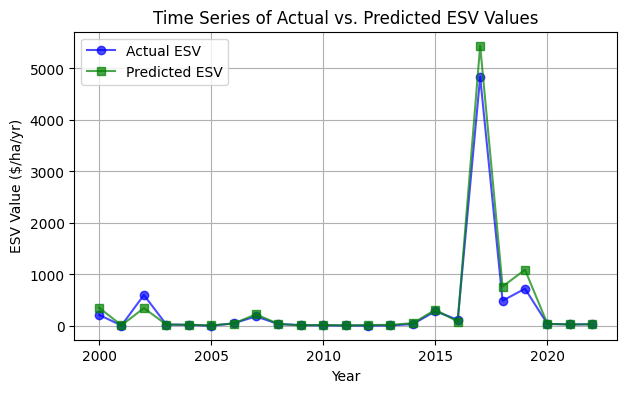

In [ ]:
import matplotlib.pyplot as plt

# Ensure X_test contains valid year information
if "Present Value Year" in X_test.columns:
    years_test = X_test["Present Value Year"]
else:
    # Use "year" instead of "Year_Pub"
    years_test = final_merged_df.loc[X_test.index, "year"]  # Fallback to year if needed

# Create a DataFrame for plotting
results_df = pd.DataFrame({'Year': years_test, 'Actual ESV': y_test, 'Predicted ESV': y_pred})

# Aggregate by year to smooth the time series
results_df = results_df.groupby("Year")[["Actual ESV", "Predicted ESV"]].mean()

# Plot actual vs. predicted ESV values over time
plt.figure(figsize=(7, 4))
plt.plot(results_df.index, results_df["Actual ESV"], label="Actual ESV", marker='o', linestyle="-", color="blue", alpha=0.7)
plt.plot(results_df.index, results_df["Predicted ESV"], label="Predicted ESV", marker='s', linestyle="-", color="green", alpha=0.7)

# Labels and title
plt.xlabel("Year")
plt.ylabel("ESV Value ($/ha/yr)")
plt.title("Time Series of Actual vs. Predicted ESV Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

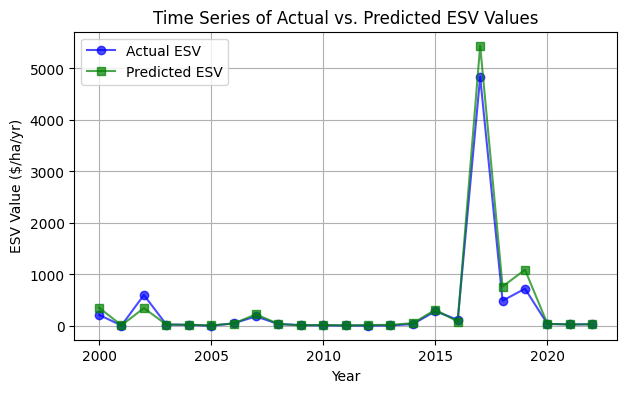

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Year' is included and properly aligned with the data
if "Present Value Year" in X_test.columns:
    years = X_test["Present Value Year"].values
else:
    years = final_merged_df.loc[X_test.index, "year"].values  # Fallback if needed

# Create DataFrame with years, actual, and predicted values
esv_results = pd.DataFrame({
    "Year": years,
    "Actual ESV": y_test.values,
    "Predicted ESV": y_pred
})

# Aggregate by year to get a single trend line
esv_results_grouped = esv_results.groupby("Year")[["Actual ESV", "Predicted ESV"]].mean()

# Plot the corrected time series
plt.figure(figsize=(7, 4))
plt.plot(esv_results_grouped.index, esv_results_grouped["Actual ESV"], label="Actual ESV", marker='o', linestyle="-", color="blue", alpha=0.7)
plt.plot(esv_results_grouped.index, esv_results_grouped["Predicted ESV"], label="Predicted ESV", marker='s', linestyle="-", color="green", alpha=0.7)

# Labels and title
plt.xlabel("Year")
plt.ylabel("ESV Value ($/ha/yr)")
plt.title("Time Series of Actual vs. Predicted ESV Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


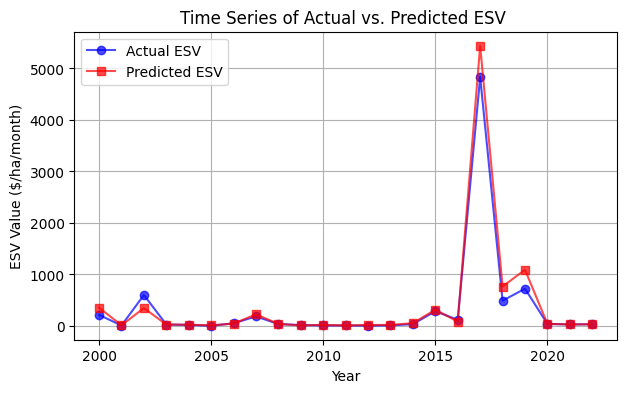

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure X_test contains valid year information
if "Present Value Year" in X_test.columns:
    years_test = X_test["Present Value Year"]
else:
    years_test = final_merged_df.loc[X_test.index, "year"]  # Fallback to Year_Pub if needed

# Create a DataFrame for plotting
results_df = pd.DataFrame({'Year': years_test, 'Actual ESV': y_test, 'Predicted ESV': y_pred})

# Aggregate by year to smooth the time series (using mean)
results_df = results_df.groupby("Year")[["Actual ESV", "Predicted ESV"]].mean().reset_index()

# Plot actual vs. predicted ESV values over time
plt.figure(figsize=(7, 4))
plt.plot(results_df["Year"], results_df["Actual ESV"], label="Actual ESV", marker='o', linestyle="-", color="blue", alpha=0.7)
plt.plot(results_df["Year"], results_df["Predicted ESV"], label="Predicted ESV", marker='s', linestyle="-", color="red", alpha=0.7)

# Labels and title
plt.xlabel("Year")
plt.ylabel("ESV Value ($/ha/month)")
plt.title("Time Series of Actual vs. Predicted ESV ")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
